In [63]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from seedtools import show_all_datasets, connect
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Flatten
from tensorflow.keras.utils import to_categorical as to_cat
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
import numpy as np 
import matplotlib.pyplot as plt
import os 


## Just ignoring warnings 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import tensorflow as tf 
tf.get_logger().setLevel('ERROR') 

**TRANSFER LEARNING IN TWO PARTS :**
-  lock pretrained model and train only new model that we have created 
- unlock both and train both but with very low lr like 0.0001(1e-4)

but why both : https://www.geeksforgeeks.org/what-is-the-difference-between-fine-tuning-and-transfer-learning/


**JUST DATA LOADING (SKIP THAT PART)**

In [49]:
TRAIN_DIR =  connect("Rock-Paper-Scissors/train")
TEST_DIR =  connect("Rock-Paper-Scissors/test")

In [50]:
train_gen = ImageDataGenerator(rescale=1/255
                               ,horizontal_flip=True,
                               shear_range=0.2,width_shift_range=0.4,
                               height_shift_range=0.4)


test_gen = ImageDataGenerator(rescale=1/255
                               ,horizontal_flip=True,
                               shear_range=0.2,width_shift_range=0.4,
                               height_shift_range=0.4)

In [51]:
train_data  = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100,100),
    batch_size=32,
    class_mode="categorical"
)
test_data  = test_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100,100),
    batch_size=32,
    class_mode="categorical"
)

Found 2520 images belonging to 3 classes.
Found 2520 images belonging to 3 classes.


**transfer learning (part 1)** :  train only new model added 

In [52]:
base_model =  VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(100,100,3)
)

for layer in base_model.layers :
    layer.trainable =  False

In [53]:
model =  Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024,activation="relu"),
    Dense(3,activation="softmax")
])
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])

In [60]:
early_stop =  EarlyStopping( # just in case of overfitting 
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

In [55]:
history_pretrained = model.fit(train_data,validation_data=test_data,epochs=3,callbacks=[early_stop])

Epoch 1/3
79/79 [==============================] - 174s 2s/step - loss: 0.4121 - acc: 0.8500 - val_loss: 0.2002 - val_acc: 0.9353
Epoch 2/3
79/79 [==============================] - 177s 2s/step - loss: 0.1764 - acc: 0.9389 - val_loss: 0.1414 - val_acc: 0.9583
Epoch 3/3
79/79 [==============================] - 153s 2s/step - loss: 0.1292 - acc: 0.9524 - val_loss: 0.1517 - val_acc: 0.9476


**transfer learning (part  2)** :  fine tuning (train both with low lr )
tip : use early stop +  reduce_lr_on_plateau 

In [56]:
for layer in  model.layers[-4:]:
    layer.trainable  = True 
    

In [57]:
adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=["acc"])
history = model.fit(train_data,validation_data=test_data,epochs=5,callbacks=early_stop)

Epoch 1/5
79/79 [==============================] - 361s 5s/step - loss: 0.3619 - acc: 0.9004 - val_loss: 0.0606 - val_acc: 0.9810
Epoch 2/5
79/79 [==============================] - 433s 6s/step - loss: 0.0790 - acc: 0.9718 - val_loss: 0.0409 - val_acc: 0.9845
Epoch 3/5
79/79 [==============================] - 419s 5s/step - loss: 0.0586 - acc: 0.9782 - val_loss: 0.0430 - val_acc: 0.9853
Epoch 4/5
79/79 [==============================] - 390s 5s/step - loss: 0.0624 - acc: 0.9786 - val_loss: 0.0282 - val_acc: 0.9913
Epoch 5/5
79/79 [==============================] - 439s 6s/step - loss: 0.0500 - acc: 0.9845 - val_loss: 0.0205 - val_acc: 0.9921


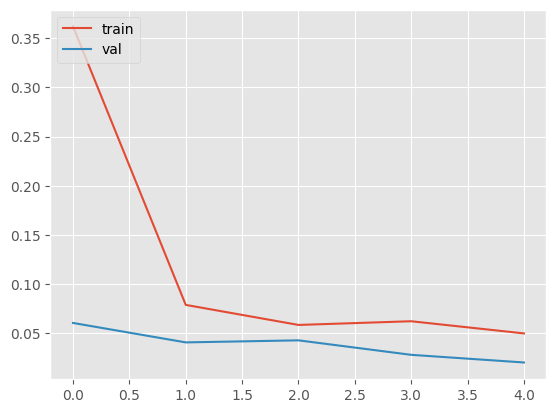

In [58]:
## Loss
plt.style.use("ggplot")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["train", "val"],loc='upper left')